# Z01.7: Explanation of Statistical Signficance Metrics


This notebook contains the analysis of Token Propensities. This is the second analysis of first Scribal Intent Study (Z01).

## Setup and Utility Functions

In [1]:
# Imports and setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binom
from IPython.display import display, HTML
import os

from qlynx.file_utils import load_pkl, store_pkl
from qlynx.stats_utils import *
from qlynx.display_utils import render_html_to_image
from voynichlib.utils import display_voynichese

%reload_ext autoreload
%autoreload 2
 

# Set Global Parameters

In [2]:
do_parametric_studies = True
MAX_BAYES = np.exp(10)
MAX_PROPENSITY = 999
THRESHOLDS = {
    'p_value': 0.01,
    'ln_bayes_factor': 5
}
THRESHOLDS['bayes_factor'] = np.exp(THRESHOLDS['ln_bayes_factor'])
reference_cohort = 'MIDDLE'
# smooth = 'laplace'
# smooth = 'laplace'
smooth = None



## Load the Token Cohort Data

In [3]:
file_path = 'voynich_data/outputs/token_cohort_data.pkl'
token_cohort_data = load_pkl(file_path)

cohorts = token_cohort_data['cohorts']
cohorts_with_randoms = token_cohort_data['cohorts_with_randoms']

corpus_by_c = token_cohort_data['corpus_by_c']
pmfs_by_c = token_cohort_data['pmfs_by_c']
token_ws_by_c = token_cohort_data['token_ws_by_c']

glyph_pmfs_by_c = token_cohort_data['glyph_pmfs_by_c']
glyphs_by_c = token_cohort_data['glyphs_by_c']

## Get Token Lengths for the Most Frequent Tokens

In [4]:
def get_top_vocabulary_tokens_lengths_dict(cohort, N_v:int=None):
    tokens = pmfs_by_c[cohort].values
    if not N_v:
        tokens = tokens[:N_v]
    token_lengths_dict = {}
    df = corpus_by_c[cohort].tokens_df()
    for token in tokens:
        df_token = df[df['token'] == token]
        token_length = df_token['token_length_min'].iloc[0]
        token_lengths_dict[token] = token_length
        pass
    pass
    return token_lengths_dict

## Function to Compile DataFrame for a Cohort

In [5]:
def compile_token_propensity_df(target_cohort, reference_cohort, p_value_threshold, bayes_threshold, consider_split_words:bool = False):
    top_token_length_dict = get_top_vocabulary_tokens_lengths_dict(reference_cohort)
    df = pd.DataFrame(columns = ['token', 'glyph_count', 'N_ref', 'n_ref', 'N_x', 'n_x', 'p_ref', 'p_x', 'p_value', 'sig_p_value', 'sig_BF', 'propensity', 'bayes', 'binom_stat_le', 'binom_stat_gt'])
    for token, w in top_token_length_dict.items():
        pmf_ref = pmfs_by_c[reference_cohort]
        N_ref = pmf_ref.total_count
        n_ref = pmf_ref.count(token) if N_ref > 0 else 0
        p_ref = pmf_ref.prob(token, smooth=smooth)
        # The following is special cases for considering potential splitting of words into tokens around drawings, 
        if consider_split_words:
            if target_cohort == 'BEFORE':
                p_ref = prob_starts_with(pmf_ref, token, smooth=smooth)
            if target_cohort == 'AFTER':
                p_ref = prob_ends_with(pmf_ref, token, smooth=smooth)
            

        pmf_x = pmfs_by_c[target_cohort]                        
        N_x = pmf_x.total_count
        n_x = pmf_x.count(token) if N_x > 0 else 0
        p_x = pmf_x.prob(token, smooth=smooth)

        p_value = calculate_binomial_probability(n_x, N_x, p_ref)

        bayes_factor = bayes_factor_binomial(n_x, N_x, p_x, p_ref)
        bayes_factor = min(MAX_BAYES, bayes_factor)

        binom_stat_le =  binom.cdf(n_x, N_x, p_ref)        
        binom_stat_gt =  binom.cdf(n_x, N_x, 1. -p_ref)        

        if target_cohort.startswith('Rand'):
            propensity = 1.
        else: 
            propensity = p_x/p_ref  if p_ref > 0 else MAX_PROPENSITY
            pass
        verdict_p_value = p_value < p_value_threshold
        verdict_bayes_factor = bayes_factor > bayes_threshold
        df.loc[len(df)] = [token,
                           top_token_length_dict[token],
                           N_ref,
                           n_ref,
                           N_x,
                           n_x,
                           p_ref,
                           p_x,
                           p_value,
                           verdict_p_value,
                           verdict_bayes_factor,
                           np.round(propensity,1),
                           bayes_factor,
                          binom_stat_le,
                          binom_stat_gt]
        pass
    df.set_index('token', inplace=True)
    pass
    return df



## Create Summary DataFrames for each Cohort

### Token Propensity DataFrame

In [6]:
token_propensity_dfs = {}
print(f"smoothing: {smooth}")
print(f"Summary Dataframes, p_value_threshold= {THRESHOLDS['p_value']}, bayes_threshold={THRESHOLDS['bayes_factor']:.1f}")
N_tokens_df = pd.DataFrame(columns = ['cohort',  'N_p', 'N_p_af', 'N_p_av', 'N_b', 'N_b_af', 'N_b_av',  'N_either', 'N_both'])

for cohort in cohorts_with_randoms:
    if cohort == 'MIDDLE':
        continue
    print(f"Creating Token Propensity DataFrame for {cohort}")
    token_propensity_dfs[cohort] = compile_token_propensity_df(cohort, 
                                                               reference_cohort, 
                                                               THRESHOLDS['p_value'], 
                                                               THRESHOLDS['bayes_factor'])
    df = token_propensity_dfs[cohort]
    # print(f"DEBUG {cohort}:  {len(df)}")
    N_p = len(df[ df['sig_p_value']])
    N_p_af =  len(df[ df['sig_p_value'] & (df['propensity']>1) ])
    N_p_av =  len(df[ df['sig_p_value'] & (df['propensity']<1) ])
    N_b = len(df[ df['sig_BF']])
    N_b_af =  len(df[ df['sig_BF'] & (df['propensity']>1) ])
    N_b_av =  len(df[ df['sig_BF'] & (df['propensity']<1) ])
    N_either =  len(df[ df['sig_BF'] | df['sig_p_value'] ])
    N_both =  len(df[ df['sig_BF'] & df['sig_p_value'] ])
    N_tokens_df.loc[len(N_tokens_df)] = [cohort,
                       N_p,
                       N_p_af,
                       N_p_av,
                       N_b,
                       N_b_af,
                       N_b_av,
                       N_either,
                       N_both]
                                             
    pass
    # print(80*'-')
pass
N_tokens_df

smoothing: None
Summary Dataframes, p_value_threshold= 0.01, bayes_threshold=148.4
Creating Token Propensity DataFrame for TOP
Creating Token Propensity DataFrame for FIRST
Creating Token Propensity DataFrame for LAST
Creating Token Propensity DataFrame for BEFORE
Creating Token Propensity DataFrame for AFTER
Creating Token Propensity DataFrame for SECOND
Creating Token Propensity DataFrame for FOURTH
Creating Token Propensity DataFrame for RAND 1
Creating Token Propensity DataFrame for RAND 2
Creating Token Propensity DataFrame for RAND 3
Creating Token Propensity DataFrame for RAND 4
Creating Token Propensity DataFrame for RAND 5
Creating Token Propensity DataFrame for RAND 6


,cohort,N_p,N_p_af,N_p_av,N_b,N_b_af,N_b_av,N_either,N_both
0,TOP,8,4,4,7,3,4,8,7
1,FIRST,42,25,17,28,14,14,42,28
2,LAST,27,17,10,17,11,6,27,17
3,BEFORE,9,7,2,6,4,2,9,6
4,AFTER,9,9,0,3,3,0,9,3
5,SECOND,2,1,1,1,1,0,2,1
6,FOURTH,1,0,1,0,0,0,1,0
7,RAND 1,0,0,0,0,0,0,0,0
8,RAND 2,1,1,0,0,0,0,1,0
9,RAND 3,0,0,0,0,0,0,0,0


In [7]:
## Function to Plot Combined Significance Tests

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom

def combined_binomial_plot(n_successes, 
                           n_trials, 
                           p_proposed, 
                           p_null, 
                           p_value_threshold=0.05, 
                           show_bayes:bool=False,
                          show_annotations:bool=False):
    """
    Combines plotting for binomial PMF and Bayes Factor on a single plot.
    
    :param n_successes: Observed number of successes (corresponds to n_x in the original function).
    :param n_trials: Total number of trials (corresponds to N_x).
    :param p_proposed: Probability of success under the proposed model.
    :param p_null: Probability of success under the null model (equivalent to p in the original function).
    :param p_value_threshold: The significance level for the binomial probability test.
    """
    # Calculate probabilities for null model
    probabilities_null = binom.pmf(range(n_trials + 1), n_trials, p_null)
    # s =0.
    # ss = 0.
    # for  i in range(n_trials + 1):
    #     s += i * probabilities_null[i]
    #     ss += probabilities_null[i]
    #     print(f"{i} : {probabilities_null[i]}   {ss}")
    # print(f"s={s}")
    
    # Calculate the p-value
    expected_number = n_trials * p_null
    tail_side = None
    if n_successes > expected_number:
        p_value = 1 - binom.cdf(n_successes - 1, n_trials, p_null)
        tail_side = 'right'
    else:
        p_value = binom.cdf(n_successes, n_trials, p_null)
        tail_side = 'left'

    # Calculate the likelihood of the data under both models
    likelihood_proposed = binom.pmf(n_successes, n_trials, p_proposed)
    likelihood_null = binom.pmf(n_successes, n_trials, p_null)
    
    # Calculate the Bayes Factor
    bayes_factor = likelihood_proposed / likelihood_null
    
    # Calculate the mean and standard deviation for p_null
    mean = N_x * p_null
    std_dev = (N_x * p_null * (1 - p_null)) ** 0.5
    max_from_null = mean + 3 * std_dev

    # Calculate the mean and standard deviation for p_proposed
    mean = N_x * p_proposed
    std_dev = (N_x * p_proposed * (1 - p_proposed)) ** 0.5
    max_from_proposed = mean + 3 * std_dev

    max_x = max(max_from_null, max_from_proposed)
    x = np.arange(0, max_x)

    proposed_pmf = binom.pmf(range(n_trials + 1), n_trials, p_proposed)
    max_y = 1.1 * np.max(proposed_pmf)
    # max_y = 1.1 * likelihood_proposed

    # Prepare to plot
    plt.figure(figsize=(12, 6))

    # Plot PMF for the null model
    bars = plt.bar(range(n_trials + 1), probabilities_null, color='lightgreen', alpha=0.6, label='Null Model PMF')

    if show_bayes:
        # Overlay PMF for the proposed model
        plt.bar(range(n_trials + 1), proposed_pmf, color='grey', alpha=0.4, label='Proposed Model PMF')
    print(f"proposed_pmf={max(proposed_pmf):.2%}")
    
    # Annotate for Bayes Factor and likelihoods
    plt.axvline(n_successes, color='purple', linestyle='dashed', label=f'Observed Successes = {n_successes}')
    if show_bayes:
        plt.axhline(likelihood_proposed, color='darkgrey', linestyle='dashed', label=f'Proposed Likelihood: {likelihood_proposed:.4f}')
        plt.axhline(likelihood_null, color='green', linestyle='dashed', label=f'Null Likelihood: {likelihood_null:.4f}')
        print(f"likelihood_proposed={likelihood_proposed:.2%}")
        print(f"likelihood_null={likelihood_null:.2%}")
        if show_annotations:
            plt.text(x=n_successes + 0.5, y=max(likelihood_proposed, likelihood_null), s=f'Bayes Factor: {bayes_factor:.2f}', fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    # Calculate and color significant tails if needed
    lower_bound = binom.ppf(p_value_threshold , n_trials, p_null)
    upper_bound = binom.ppf(1 - p_value_threshold , n_trials, p_null)
    # lower_bound = binom.ppf(p_value_threshold / 2, n_trials, p_null)
    # upper_bound = binom.ppf(1 - p_value_threshold / 2, n_trials, p_null)
    for i in range(len(bars)):
        if (tail_side == 'left' and i <= lower_bound) or (tail_side == 'right' and i >= lower_bound):
        # if i <= lower_bound or i >= upper_bound:
            bars[i].set_alpha(0.8)
            bars[i].set_color('blue')
    
    # Set the x-axis limit to 3 standard deviations above the mean
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)

    # Set x-axis ticks to ensure every value is marked
    plt.xticks(x)

    plt.title('Binomial Distribution Significance Testings')
    plt.xlabel('Number of Successes')
    plt.ylabel('Probability Mass')
    if show_annotations:
        plt.legend()
    plt.show()
    

    return p_value, bayes_factor


## Function to Extract Specific Case

In [59]:
def extract_df(cohort, stat_type, component_type):
    # print(f"'{cohort}' Compared to 'MIDDLE'")
    if component_type == 'tokens':
        df = token_propensity_dfs[cohort]
    elif component_type == 'glyphs':
       df = glyph_propensity_dfs[cohort]

    if stat_type == 'p_value':
        df = df[df['sig_p_value']]
        df.sort_values(by='p_value', ascending=False)
    elif stat_type == 'bayes':
        df = df[df['sig_BF']]        
        df.sort_values(by='bayes', ascending=False)
    elif stat_type == 'both':
        df = df[(df['sig_p_value']) & (df['sig_BF'])]
        
    # print(len(df))
    return df



In [60]:
extract_df('BEFORE', 'both', 'tokens')

,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,349,3,0.047281,0.008596,4.677319e-05,True,True,0.2,5751.381813,0.000047,0.0
chor,4,3807,107,349,0,0.028106,0.000000,4.775047e-05,True,True,0.0,20942.200290,0.000048,0.0
s,1,3807,75,349,19,0.019701,0.054441,8.424169e-05,True,True,2.8,1645.754299,0.999973,0.0
dy,2,3807,28,349,23,0.007355,0.065903,4.773959e-15,True,True,9.0,22026.465795,1.000000,0.0
dam,3,3807,7,349,5,0.001839,0.014327,5.220567e-04,True,True,7.8,377.795542,0.999946,0.0
qotaiin,7,3807,2,349,4,0.000525,0.011461,4.004931e-05,True,True,21.8,5089.788084,0.999999,0.0


In [61]:
extract_df('TOP', 'both', 'tokens')

,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,847,10,0.047281,0.011806,8.946149e-09,True,True,0.2,22026.465795,8.946149e-09,0.0
chy,3,3807,72,847,5,0.018913,0.005903,1.266470e-03,True,True,0.3,194.413453,1.266470e-03,0.0
shol,4,3807,53,847,28,0.013922,0.033058,3.568536e-05,True,True,2.4,3514.458801,9.999861e-01,0.0
chaiin,6,3807,26,847,0,0.006830,0.000000,3.014110e-03,True,True,0.0,331.772920,3.014110e-03,0.0
kchy,4,3807,25,847,0,0.006567,0.000000,3.770810e-03,True,True,0.0,265.195043,3.770810e-03,0.0
shor,4,3807,23,847,20,0.006042,0.023613,4.332600e-07,True,True,3.9,22026.465795,9.999999e-01,0.0
chcphy,6,3807,1,847,3,0.000263,0.003542,1.550233e-03,True,True,13.5,153.173337,9.999150e-01,0.0


In [62]:
extract_df('FIRST', 'both', 'tokens')

,glyph_count,N_ref,n_ref,N_x,n_x,p_ref,p_x,p_value,sig_p_value,sig_BF,propensity,bayes,binom_stat_le,binom_stat_gt
token,,,,,,,,,,,,,,
chol,4,3807,180,998,10,0.047281,0.010020,2.965859e-11,True,True,0.2,22026.465795,2.965859e-11,0.0
chor,4,3807,107,998,7,0.028106,0.007014,1.861640e-06,True,True,0.2,22026.465795,1.861640e-06,0.0
s,1,3807,75,998,4,0.019701,0.004008,1.964432e-05,True,True,0.2,12288.718464,1.964432e-05,0.0
chy,3,3807,72,998,1,0.018913,0.001002,1.072737e-07,True,True,0.1,22026.465795,1.072737e-07,0.0
cthy,4,3807,53,998,0,0.013922,0.000000,8.386267e-07,True,True,0.0,22026.465795,8.386267e-07,0.0
sho,3,3807,46,998,28,0.012083,0.028056,5.337535e-05,True,True,2.3,2382.238642,9.999786e-01,0.0
chey,4,3807,46,998,0,0.012083,0.000000,5.382892e-06,True,True,0.0,22026.465795,5.382892e-06,0.0
cho,3,3807,38,998,1,0.009982,0.001002,4.963764e-04,True,True,0.1,815.194158,4.963764e-04,0.0
cthol,5,3807,36,998,1,0.009456,0.001002,8.021052e-04,True,True,0.1,507.035519,8.021052e-04,0.0


## Display of Significance Tests for Case of Sample Tokens

In [63]:
token = 'chy'
df = extract_df('TOP', 'both', 'tokens')
token_props = df.loc[token]
p_x = token_props['p_x']
p_ref = token_props['p_ref']
n_x = token_props['n_x']
N_x = token_props['N_x']

print(f"p_x={p_x}")
print(f"p_ref={p_ref}")
print(f"n_x={n_x}")
print(f"N_x={N_x}")
token_props

num_tokens_in_target = pmfs_by_c[cohort].total_count
expected_value = int(np.round(p_ref * num_tokens_in_target))
print(f"num tokens in target= {num_tokens_in_target}")
print(f"expected value = {expected_value}")

display_voynichese('chy',render=True)

p_x=0.0059031877213695395
p_ref=0.018912529550827423
n_x=5
N_x=847
num tokens in target= 349
expected value = 7


proposed_pmf=17.60%


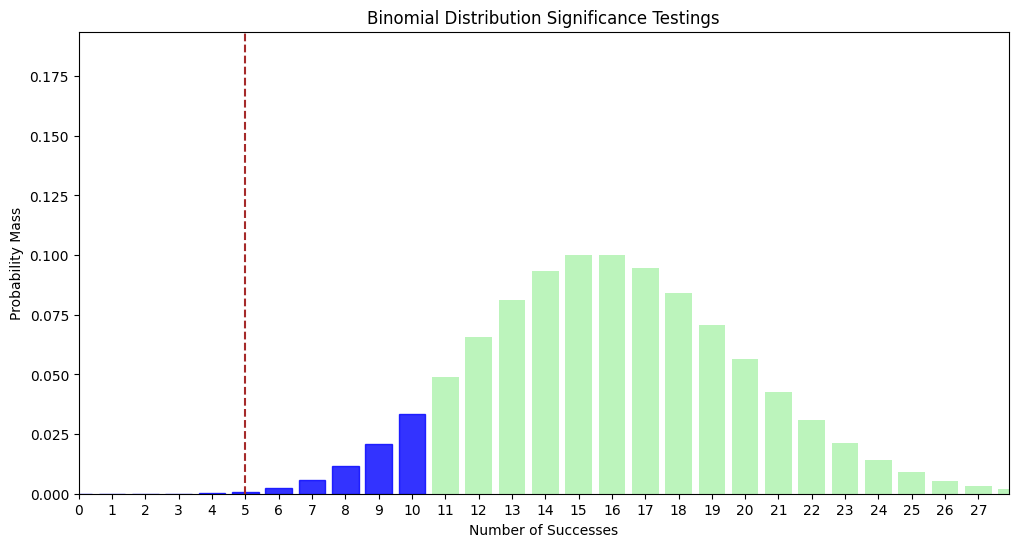

proposed_pmf=17.60%
likelihood_proposed=17.60%
likelihood_null=0.09%


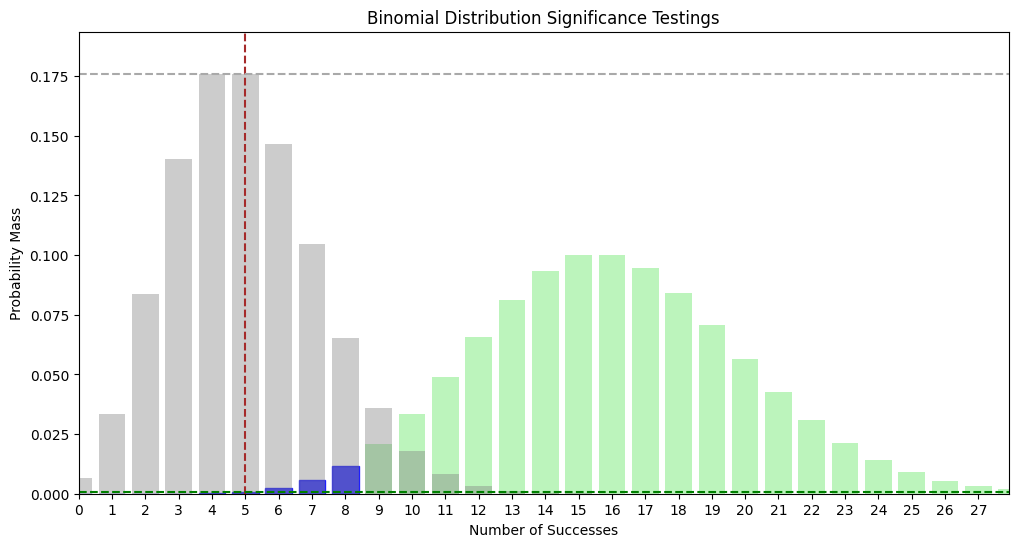

(0.001266469871801968, 194.41345322609993)

In [170]:
combined_binomial_plot(n_x, N_x, p_x, p_ref, p_value_threshold=0.05, show_bayes=False)
combined_binomial_plot(n_x, N_x, p_x, p_ref, p_value_threshold=0.01, show_bayes=True)

## Contrived for Better Display Example

In [88]:
0.0189 * 890

16.821

nn_x = 8.0
m_1 = 8.4016
m_2 = 16.821
proposed_pmf=13.88%


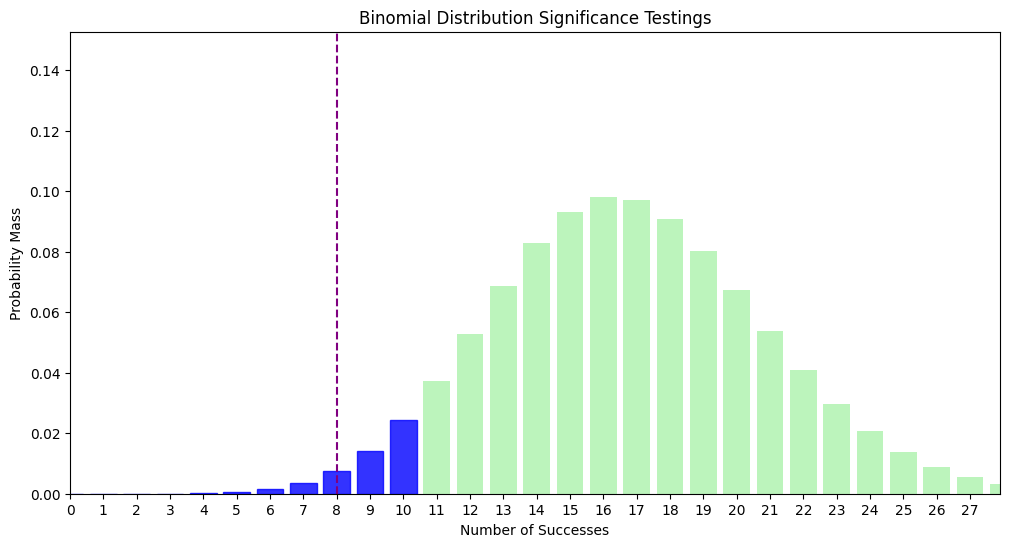

(0.013289763892693204, 18.358034596205023)

In [175]:
# nn_x = 8
NN_x = 890
pp_x = 0.0059*(8/5)
nn_x = np.round(pp_x * NN_x)
pp_ref = 0.0189
print(f"nn_x = {nn_x}")
print(f"m_1 = {pp_x*NN_x}")
print(f"m_2 = {pp_ref*NN_x}")
combined_binomial_plot(nn_x, NN_x, pp_x, pp_ref, p_value_threshold=0.05, show_bayes=False, show_annotations=False)
# combined_binomial_plot(8, 890, 0.012, 0.0189, p_value_threshold=0.05, show_bayes=True, show_annotations=False)

In [142]:
# binom.cdf(n_successes, n_trials, p_null)
binom.cdf(8, 890, 0.0189)

0.013289763892693204

In [128]:
1 - binom.cdf(8 - 1, 890, 0.00944)

0.6024344167013452

In [127]:
0.0059*(8/5)

0.00944

In [131]:
890*0.0189

16.821

In [163]:
.1388/.0076


18.263157894736842

In [168]:
np.log(.1388/.0076)

2.9048858007804186